# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents<a id='4.1'></a>
* [4.1 Contents](#4.1)
* [4.2 Introduction](#4.2)
* [4.3 Imports](#4.3)
* [4.4 Load Data](#4.4)
* [4.5 Create dummy features for categorical variables](#4.5)
* [4.6 Train/Test Split](#4.6)
* [4.7 Scale the data](#4.7)
* [4.8 Model Comparison](#4.8)
    * [4.8.1 Linear Regression](#4.8.1)
    * [4.8.2 Random Forest Model](#4.8.2)
  

## 4.2 Introduction<a id='4.2'></a>

The main tasks in this notebook are:
- Create dummy or indicator features for categorical variables
- Standardize the magnitude of numeric features using a scaler
- Split your data into testing and training datasets

## 4.3 Imports<a id='4.3'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
import datetime

from library.sb_utils import save_file

## 4.4 Load Data<a id='4.4'></a>

In [2]:
student_data = pd.read_csv('../data/student_data_cleaned.csv')
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
col_info = pd.read_csv('../data/data_columns.csv')
col_info['dtype'] = student_data.dtypes.values
col_info

,order,name,meaning,notes,dtype
0,1,school,student's school,binary: 'GP' - Gabriel Pereira or 'MS' - Mousi...,object
1,2,sex,student's sex,binary: 'F' - female or 'M' - male,object
2,3,age,student's age,numeric: from 15 to 22,int64
3,4,address,student's home address type,binary: 'U' - urban or 'R' - rural,object
4,5,famsize,family size,binary: 'LE3' - less or equal to 3 or 'GT3' - ...,object
5,6,Pstatus,parent's cohabitation status,binary: 'T' - living together or 'A' - apart,object
6,7,Medu,mother's education,"numeric: 0 - none, 1 - primary education 4th g...",int64
7,8,Fedu,father's education,"numeric: 0 - none, 1 - primary education 4th g...",int64
8,9,Mjob,mother's job,"nominal: 'teacher', 'health' care related, civ...",object
9,10,Fjob,father's job,"nominal: 'teacher', 'health' care related, civ...",object


## 4.5 Create dummy features for categorical variables<a id='4.5'></a>

The Col_info dataframe shows that all the "object" variables are either nominal or binary. Therefore, we only create dummy features for these variables.

In [4]:
data_dummies = pd.get_dummies(student_data)
print(data_dummies.shape)
data_dummies.head().T

(357, 59)


,0,1,2,3,4
age,18,17,15,15,16
Medu,4,1,1,4,3
Fedu,4,1,1,2,3
traveltime,2,1,1,1,1
studytime,2,2,2,3,2
failures,0,0,3,0,0
famrel,4,5,4,3,4
freetime,3,3,3,2,3
goout,4,3,2,2,2
Dalc,1,1,2,1,1


In [5]:
data_dummies.dtypes

age                  int64
Medu                 int64
Fedu                 int64
traveltime           int64
studytime            int64
failures             int64
famrel               int64
freetime             int64
goout                int64
Dalc                 int64
Walc                 int64
health               int64
absences             int64
G1                   int64
G2                   int64
G3                   int64
school_GP            uint8
school_MS            uint8
sex_F                uint8
sex_M                uint8
address_R            uint8
address_U            uint8
famsize_GT3          uint8
famsize_LE3          uint8
Pstatus_A            uint8
Pstatus_T            uint8
Mjob_at_home         uint8
Mjob_health          uint8
Mjob_other           uint8
Mjob_services        uint8
Mjob_teacher         uint8
Fjob_at_home         uint8
Fjob_health          uint8
Fjob_other           uint8
Fjob_services        uint8
Fjob_teacher         uint8
reason_course        uint8
r

## 4.6 Train/Test Split<a id='4.6_Train/Test_Split'></a>

Create X, y variables for train/test split. 
- Because G3 is strongly related to G1 and G2, the weights of these two variables are way hihger than than other variables. Therefore, we remove these two feature from the X.

In [6]:
# X0 is generated for comparison
X0 = data_dummies.drop(columns = ['G3'])
X = data_dummies.drop(columns = ['G1','G2','G3'])
y = data_dummies['G3']
print(X.shape,'\n', y.shape)

(357, 56) 
 (357,)


We will split the data with test_size = 0.25, i.e., training uses 75% of data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y, test_size=0.25, random_state=47)

In [8]:
print(X_train.shape,'\n', X_test.shape)

(267, 56) 
 (90, 56)


## 4.7 Scale the data<a id='4.7'></a>

The standardscaler is used to scale the data.

In [9]:
scaler = StandardScaler()
X0_train_scaled = scaler.fit_transform(X0_train)
X0_test_scaled = scaler.transform(X0_test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape,'\n', X_test_scaled.shape)

(267, 56) 
 (90, 56)


## 4.8 Model Comparison<a id='4.8'></a>

### 4.8.1 Linear Regression<a id='4.8.1'></a>

First, we use all the features (i.e., X0) to train the model.

In [10]:
lm = LinearRegression()
lm.fit(X0_train_scaled, y0_train)
y0_pred = lm.predict(X0_test_scaled)
print('The r2 score is ', round(r2_score(y0_test, y0_pred),3), '\n',
      'The mean squared error is ', round(mean_squared_error(y0_test, y0_pred),3)
)

The r2 score is  0.898 
 The mean squared error is  0.915


Second, we use the features without `G1` and `G2`(i.e., X) to train the model. We can observe that hte r2 score is reduced from 0.898 to 0.052, indicating the dramtaic impact of G1 and G2 on the target variable G3. It confirms the necessarity of removing the G1 and G2 from the features to investigate the impact of other features on student's grade.

In [11]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
print('The r2 score for the training data is', round(lm.score(X_train_scaled, y_train),3))
y_pred = lm.predict(X_test_scaled)
print('The r2 score is ', round(r2_score(y_test, y_pred),3), '\n',
      'The mean squared error is ', round(mean_squared_error(y_test, y_pred),3)
)

The r2 score for the training data is 0.361
The r2 score is  0.077 
 The mean squared error is  8.274


In [38]:
rf_cv_results = cross_validate(lm, X_train_scaled, y_train, cv=5,return_train_score=True)
rf_cv_scores = rf_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_cv_scores),4), '\n',
      'The cv score std is ', round(np.std(rf_cv_scores),4))

The cv score mean is  0.0392 
 The cv score std is  0.158


As the mean of the cv score of the linear regression is too small and the std is too large, this model may be underfitted. We need to try other models.

### 4.8.2 Random Forest Model<a id='4.8.2'></a>

In [40]:
RF = RandomForestRegressor(n_estimators=100, random_state=47)
RF.fit(X_train_scaled, y_train)
print('The r2 score for the training data is', round(RF.score(X_train_scaled, y_train),3))
y_pred = RF.predict(X_test_scaled)
print('The r2 score for the test dataset is ', round(r2_score(y_test, y_pred),3))

The r2 score for the training data is 0.884
The r2 score for the test dataset is  0.132


In [42]:
rf_cv_results = cross_validate(RF, X_train_scaled, y_train, cv=10,return_train_score=True)
rf_cv_scores = rf_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(rf_cv_scores),3))

The cv score mean is  0.139 
 The cv score std is  0.14


The random forest model yields a much better cv score `mean` than linear regression but the `std` is still large.

Next step, we are trying to optimize the performance of the random forest model by GridSearchCV.

**Hyperparameter search using GridSearchCV**

Random forest has a number of hyperparameters that can be explored.
- A pipeline is created for optimization of scaler and regressor simultaneouly when necessary.
- The scenarios below consider:
    * StandardScaler(), MinMaxScaler()
    * n_estimate = [1-1000]
    * mean_squared_error and r2_score are tested as the scorer.

**Case 1: Optimize n_estimator using r2_score as the scorer**

`GridSearchCV` use r2_score as the scorer to optimize the n-estimator for the Random Forest model.

In [15]:
# define the range of n_estimator
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=50)]
grid_params = {'n_estimators': n_est}

# implement optimization
rf_grid_cv = GridSearchCV(RF, param_grid=grid_params, cv=10, n_jobs=-1)
rf_grid_cv.fit(X_train_scaled, y_train)
rf_grid_cv.best_params_

{'n_estimators': 686}

In [16]:
# Ouput the optimized scorer
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train_scaled, y_train, cv=10,return_train_score=True)
rf_best_scores = rf_best_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_best_scores),4), '\n',
      'The cv score std is ', round(np.std(rf_best_scores),4))

The cv score mean is  0.1511 
 The cv score std is  0.148


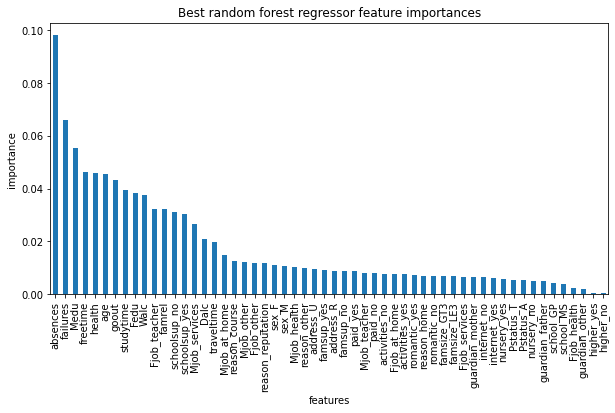

In [17]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.feature_importances_
# imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [25]:
feature_importance = pd.DataFrame(rf_feat_imps).reset_index()

In [26]:
datapath = '../data'
save_file(feature_importance, 'feature importance.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data\feature importance.csv"


**Case 2: Optimize n_estimator using mean_squared_error as the scorer**

`GridSearchCV` use mean_squared_error as the scorer to optimize the n-estimator for the Random Forest model.

In [495]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=50)]
grid_params = {'n_estimators': n_est}

scorers = {'mse': make_scorer(mean_squared_error)}

rf_grid_cv = GridSearchCV(RF, param_grid=grid_params, refit='mse', cv=10, scoring=scorers, n_jobs=-1)
rf_grid_cv.fit(X_train_scaled, y_train)
print(rf_grid_cv.best_params_)

rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train_scaled, y_train, cv=10,return_train_score=True)
rf_best_scores = rf_best_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_best_scores),4), '\n',
      'The cv score std is ', round(np.std(rf_best_scores),4))

{'n_estimators': 10}
The cv score mean is  0.053 
 The cv score std is  0.1776


It's hard to choose a proper scorer. The r2 score is used anyway.
* By using the mean_squared_error, the mean and std of the cv score are 0.0839 and 0.0887.
* By using the r2_score, the mean and std of the cv score are 0.1509 and 0.1458.

**Case 3: Optimize n_estimator & scaler simultaneously**

In [496]:
# build the pipeline
RF_pip = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=47))
])

# set the parameter grid
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=50)]
grid_params = {'scaler':[StandardScaler(), MinMaxScaler()], 
               'regressor':[RandomForestRegressor(random_state=47)],
               'regressor__n_estimators':n_est}

# define the scorer
scorers = {'mse': make_scorer(r2_score)}

# fine the best parameters
rf_grid_cv = GridSearchCV(RF_pip, param_grid=grid_params, refit='mse', scoring=scorers, cv=10, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
rf_grid_cv.best_params_

{'regressor': RandomForestRegressor(n_estimators=517, random_state=47),
 'regressor__n_estimators': 517,
 'scaler': StandardScaler()}

In [497]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train_scaled, y_train, cv=10,return_train_score=True)
rf_best_scores = rf_best_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_best_scores),4), '\n',
      'The cv score std is ', round(np.std(rf_best_scores),4))

The cv score mean is  0.1551 
 The cv score std is  0.1476


The best parameters are MinMaxScaler and n_estimator=14 in this case. But the cv score is -0.2882.

The cell below is stored for next step: Modelling.

In [498]:
# Initialze the estimators
# rg1 = RandomForestRegressor(random_state=47)
# rg2 = LinearRegression()

# param1 = {}
# n_est = [int(n) for n in np.logspace(start=1, stop=3, num=50)]
# param1['classifier__n_estimators'] = n_est
# param1['classifier__max_depth'] = [5, 10, 20]
# param1['classifier'] = [rg1]

# param2 = {}
# param2['classifier__normalize'] = [True, False]
# param2['classifier'] = [rg2]


# pipeline = Pipeline([('classifier', rg1)])
# grid_params = [param1, param2]

# scorers = {'mse': make_scorer(mean_squared_error)}

# rf_grid_cv = GridSearchCV(Pipeline, param_grid=grid_params, refit='mse', scoring=scorers, cv=5, n_jobs=-1)
# rf_grid_cv.fit(X_train_scaled, y_train)
# rf_grid_cv.best_params_

**Exploring PCA and modeling**

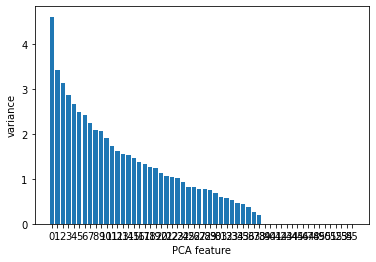

In [499]:
pca = PCA()
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)
# explained_variance = pca.explained_variance_ratio_
# explained_variance
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [500]:
r2score = []

for i in range(50):
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=i+1)
    X_train_scaled = pca.fit_transform(X_train_scaled)
    X_test_scaled = pca.transform(X_test_scaled)

    RF = RandomForestRegressor(random_state=47)
    RF_model = RF.fit(X_train_scaled, y_train)
    y_test_predict = RF_model.predict(X_test_scaled)
    r2score.append(r2_score(y_test, y_test_predict))

-0.32766100411613297 0.031166930521330904


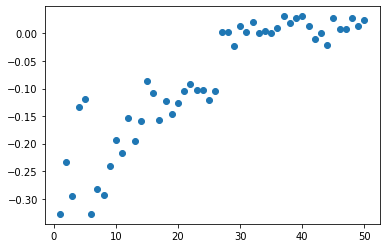

In [501]:
print(min(r2score), max(r2score))
plt.scatter(np.array(range(50)) + 1, r2score)
plt.show();

In [502]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=1)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

RF = RandomForestRegressor(random_state=47)
RF.fit(X_train_scaled, y_train)
y_test_predict = RF.predict(X_test_scaled)
print('The r2 score is ', r2_score(y_test, y_test_predict), '\n',
      'The mean squared error is ', mean_squared_error(y_test, y_test_predict)
)

rf_best_cv_results = cross_validate(RF, X_train_scaled, y_train, cv=10,return_train_score=True)
rf_best_scores = rf_best_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_best_scores),4), '\n',
      'The cv score std is ', round(np.std(rf_best_scores),4))

The r2 score is  -0.32746921160226306 
 The mean squared error is  11.904776666666665
The cv score mean is  -0.638 
 The cv score std is  0.2817
